# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [47]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def get_dprinter(debug=True):
    def dprint(*args, **kwargs):
        if debug:
            print(*args, **kwargs)     
    return dprint

    
def build_hamiltonian(mol):
    E_nuc = mol.energy_nuc()
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    H_mat = H_mat + E_nuc * np.eye(H_mat.shape[0])
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    E_HF = myhf.e_tot

    return H_mat, E_fci, E_HF


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=5000, step_starting_shift_upd=500, n_prod=2500,
           shift_upd_interval=10, dt=0.001, damping=0.05, debug=True):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて基底状態エネルギーを推定する。

    Args:
        mol: PySCFのMoleculeオブジェクト
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        n_prod: E_projの平均を計算するステップ数（処理完了時からこのステップ数遡って平均を取る）
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ
        debug: デバッグモード
        

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """
    dprint = get_dprinter(debug)
    
    H_mat, E_fci, E_HF = build_hamiltonian(mol)
    H_mat = H_mat - np.eye(H_mat.shape[0]) * E_HF
    dprint(f"--- K Matrix shape:{H_mat.shape} ---")
    dprint(H_mat)
    
    E_est = 0
    hist_population = np.zeros(n_steps)
    hist_shift = np.zeros(n_steps)
    hist_energy = np.zeros(n_steps)
    
    diag_H = np.diag(H_mat)    
    n_det = H_mat.shape[0]
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    # walkers = {ref_det_idx: init_n_walker}
    walkers = np.zeros(n_det, dtype=np.int32)
    walkers[ref_det_idx] = init_n_walker

    tqdm_pbar = tqdm(range(n_steps))
    for step in tqdm_pbar:
        target_det_idx = np.flatnonzero(walkers)
        target_walkers = walkers[target_det_idx]
        n_target_det = target_det_idx.shape[0]
        
        # ----- Spawning Step -----
        # walkerのspawn先determinantをランダムに決める
        # spawn元インデックスを避けてspawn先インデックスを生成
        # det_idx = np.arange(n_target_det)
        t_idx = np.random.randint(0, n_det-1, size=n_target_det)
        t_idx += (t_idx >= target_det_idx)

        # spawn確率を計算
        h_ij = H_mat[target_det_idx, t_idx]
        p_gen = 1/(n_det-1)
        prob_spawn = dt * abs(h_ij) / p_gen
        frac_prob_spawn, int_prob_spawn = np.modf(prob_spawn)

        # spawn確率の整数部分は確定spawn
        n_spawn = int_prob_spawn.astype(np.int32)
        # 小数部分は確率的にspawn
        n_spawn += np.random.binomial(abs(target_walkers), frac_prob_spawn)

        # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerをspawn
        signs = np.sign(target_walkers)
        signs[h_ij > 0] *= -1
        n_spawn *= signs
        # new_walkers = np.zeros(n_target_det, dtype=np.int32)
        # print('new_walkers:', new_walkers)
        # print('t_idx:', t_idx)
        # print('n_spawn:', n_spawn)
        # np.add.at(new_walkers, t_idx, n_spawn)

        # ----- Diagonal Step (Death/Cloning) -----
        prob_death = dt * (diag_H[target_det_idx] - shift)
        signs = np.sign(target_walkers)

        # prob_deathの確率でdeath/cloneする（対象となるwalkerの数をカウントする）
        n_dc = np.random.binomial(abs(target_walkers), abs(prob_death))
        # prob_death>0ならwalkerを削除し、<0ならwalkerを複製
        n_dc[prob_death > 0] *= -1
        target_walkers = signs * (abs(target_walkers) + n_dc)
        walkers[target_det_idx] = target_walkers

        # ----- Annihilation Step -----
        # walkers += new_walkers
        np.add.at(walkers, t_idx, n_spawn)

        # # ---- Shift Update -----
        current_pop = np.sum(abs(walkers))
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift

        pre_pop = current_pop
        hist_shift[step] = shift
        hist_population[step] = current_pop

        # ----- Energy Estimation (Projected Energy) -----
        # E_HF2 = diag_H[ref_det_idx]  # これはE_HFではない
        row0 = H_mat[ref_det_idx]
        num_ref = walkers[ref_det_idx]

        # 論文では、singles/doublesに限定して合計している
        # この実装だとそもそもFCI行列の成分がsingles/doubles以外が0になっているので、
        # 全部を合計していて、結局singles/doublesだけが合計されることになっている
        s = row0 * walkers / num_ref
        E_proj = E_HF + np.sum(s[1:])

        # # E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        
        # # 生成したコードでは論文にはない項を足していた
        # # これはハミルトニアンに各反発エネルギーが含まれているかいないかの解釈が論文と異なっているため？
        # # これを含めなければ近い値に収束するので、コメントアウトしておく
        # # E_proj += mol.energy_nuc()
        hist_energy[step] = E_proj

        if step % 1000 == 0:
            tqdm_pbar.set_postfix(n_walkwers=current_pop, shift=f"{shift:.5f}", E_proj=f"{E_proj:.6f}")
            dprint(f'{step} step')
            log_n_walkers(walkers, debug=debug)

    # n_prod件のhist_energyデータを10分割して平均を取り、標準偏差を求める
    n_block = 10
    hist_energy_prod = np.array(hist_energy[-n_prod:])
    block_size = len(hist_energy_prod) // n_block
    hist_energy_prod = hist_energy_prod[:n_block * block_size]  # 小数分を切り捨てる
    blocks = hist_energy_prod.reshape(n_block, block_size)
    block_means = blocks.mean(axis=1)
    E_sd = np.std(block_means, ddof=1)
    E_est = np.mean(block_means)
    
    # E_est = np.mean(hist_energy_prod) # 最後のn_prodステップの平均
    avg_shift = np.mean(hist_shift[-n_prod:]) # 最後のn_prodステップの平均
    
    dprint('\n---- Walkers (result) ----')
    log_n_walkers(walkers, debug=debug)

    return E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy


def log_n_walkers(walkers, debug=True, limit=10):
    dprint = get_dprinter(debug)
    idx = np.argsort(abs(walkers))[::-1]
    sorted_arr = walkers[idx]
    mask = sorted_arr != 0

    idx = idx[mask]
    sorted_arr = sorted_arr[mask]

    for i, v in zip(idx[:limit], sorted_arr[:limit]):
      dprint(f"  {v} walkers on {i}th determinant")

    if sorted_arr.shape[0] > limit:
        dprint("  ... more")
    

def plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')
    plt.grid(True)  

    E_corr = np.full_like(hist_shift, E_fci - E_HF)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift, label="Shift")
    plt.plot(E_corr, linestyle="--", label=r"${E_{corr}}$")
    plt.xlabel('Step')
    plt.ylabel('Shift')
    plt.legend()
    plt.grid(True)  

    E_fci_arr = np.full_like(hist_energy, E_fci)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy, label=r"${E_{proj}}$")
    plt.plot(E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    plt.legend()
    plt.grid(True)  
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出る

--- K Matrix shape:(4, 4) ---
[[ 0.00000000e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16  7.67196412e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01  7.67196412e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  1.57937745e+00]]


 10%|████▎                                     | 2028/20000 [00:00<00:00, 20275.96it/s, E_proj=-1.133233, n_walkwers=48, shift=0.70000]

0 step
  3 walkers on 0th determinant
1000 step
  7 walkers on 0th determinant
  -1 walkers on 3th determinant
2000 step
  13 walkers on 0th determinant
  -1 walkers on 3th determinant
3000 step
  20 walkers on 0th determinant
  -2 walkers on 3th determinant
4000 step
  44 walkers on 0th determinant
  -4 walkers on 3th determinant


 22%|█████████▏                                | 4403/20000 [00:00<00:00, 22308.31it/s, E_proj=-1.133616, n_walkwers=94, shift=0.70000]

5000 step
  86 walkers on 0th determinant
  -8 walkers on 3th determinant


 45%|██████████████████                      | 9059/20000 [00:00<00:00, 22994.60it/s, E_proj=-1.137270, n_walkwers=2026, shift=0.70000]

6000 step
  191 walkers on 0th determinant
  -15 walkers on 3th determinant
7000 step
  408 walkers on 0th determinant
  -39 walkers on 3th determinant
8000 step
  891 walkers on 0th determinant
  -99 walkers on 3th determinant
9000 step
  1820 walkers on 0th determinant
  -206 walkers on 3th determinant


 45%|██████████████████                      | 9059/20000 [00:00<00:00, 22994.60it/s, E_proj=-1.137578, n_walkwers=7443, shift=0.41236]

10000 step
  3855 walkers on 0th determinant
  -384 walkers on 3th determinant
11000 step
  6676 walkers on 0th determinant
  -767 walkers on 3th determinant


 69%|██████████████████████████▏           | 13759/20000 [00:00<00:00, 23126.44it/s, E_proj=-1.137039, n_walkwers=16662, shift=0.05556]

12000 step
  9544 walkers on 0th determinant
  -1156 walkers on 3th determinant
13000 step
  12103 walkers on 0th determinant
  -1386 walkers on 3th determinant
14000 step
  13744 walkers on 0th determinant
  -1523 walkers on 3th determinant
15000 step
  14985 walkers on 0th determinant
  -1677 walkers on 3th determinant


 81%|██████████████████████████████▋       | 16177/20000 [00:00<00:00, 23466.28it/s, E_proj=-1.137053, n_walkwers=17635, shift=0.03343]

16000 step
  15859 walkers on 0th determinant
  -1776 walkers on 3th determinant


100%|█████████████████████████████████████| 20000/20000 [00:00<00:00, 23199.66it/s, E_proj=-1.137070, n_walkwers=19169, shift=-0.01427]


17000 step
  16601 walkers on 0th determinant
  -1904 walkers on 3th determinant
18000 step
  16981 walkers on 0th determinant
  -1968 walkers on 3th determinant
19000 step
  17237 walkers on 0th determinant
  -1932 walkers on 3th determinant

---- Walkers (result) ----
  17452 walkers on 0th determinant
  -1981 walkers on 3th determinant
E_fci=-1.137283834488502, E_HF=-1.1167593073964248
------------------------------
FCI Energy: -1.137284 Ha
FCIQMC Energy: -1.137007 ±  0.000812 Ha


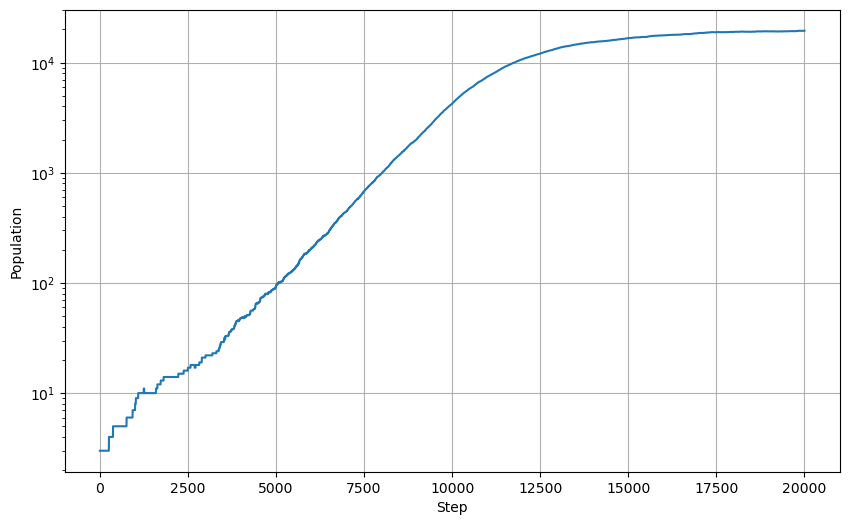

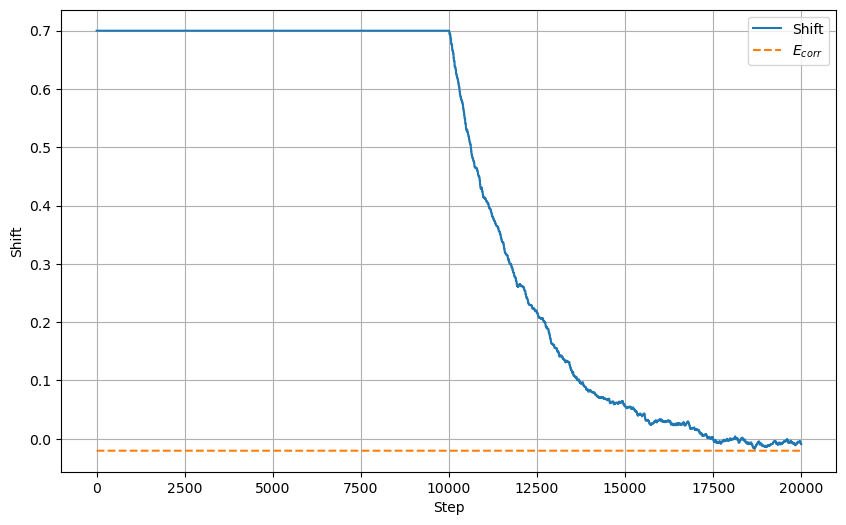

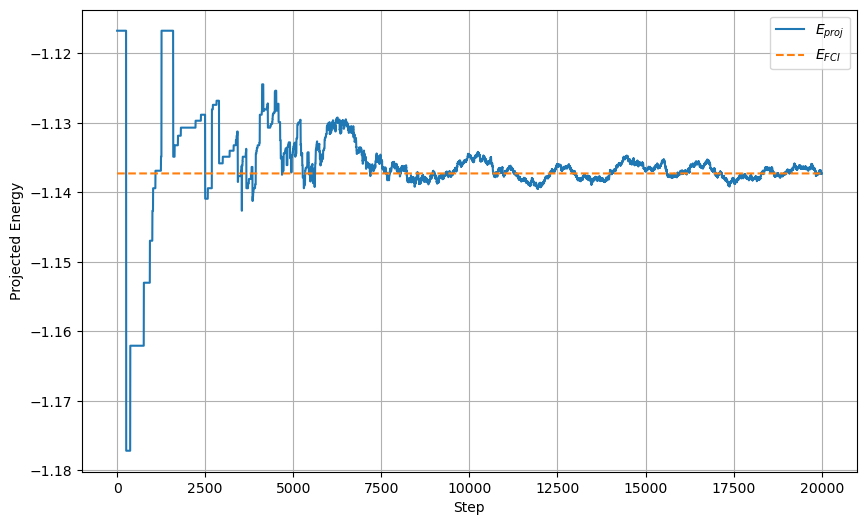

In [49]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)

E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=20000, n_prod=10000, step_starting_shift_upd=10000)

print(f"E_fci={E_fci}, E_HF={E_HF}")

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
# print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- K Matrix shape:(9, 9) ---
[[-4.44089210e-16  2.78282448e-17 -9.82897130e-09  2.78282448e-17
   1.44076448e-01 -4.65022949e-17 -9.82897130e-09 -4.65022949e-17
   1.44076569e-01]
 [ 2.78282448e-17  6.29766527e-01 -4.94150488e-17  1.44076448e-01
   2.23904423e-12 -9.56437226e-02 -4.65022949e-17 -9.56440818e-02
  -2.23896578e-12]
 [-9.82897130e-09 -4.94150488e-17  6.29784244e-01 -4.65022949e-17
  -9.56437226e-02 -2.23892764e-12  1.44076569e-01 -2.23896578e-12
   9.56396165e-02]
 [ 2.78282448e-17  1.44076448e-01 -4.65022949e-17  6.29766527e-01
   2.23904423e-12 -9.56440818e-02 -4.94150488e-17 -9.56437226e-02
  -2.23896578e-12]
 [ 1.44076448e-01  2.23904423e-12 -9.56437226e-02  2.23904423e-12
   1.35961761e+00 -3.38168990e-16 -9.56437226e-02 -3.38168990e-16
   7.58871399e-02]
 [-4.65022949e-17 -9.56437226e-02 -2.23892764e-12 -9.5

 10%|████▏                                     | 2001/20000 [00:00<00:00, 19938.67it/s, E_proj=-1.281934, n_walkwers=53, shift=0.80000]

0 step
  1 walkers on 0th determinant
1000 step
  1 walkers on 0th determinant
2000 step
  2 walkers on 0th determinant
3000 step
  14 walkers on 0th determinant
  -4 walkers on 4th determinant
4000 step
  40 walkers on 0th determinant
  -8 walkers on 4th determinant
  -2 walkers on 8th determinant
  -2 walkers on 6th determinant
  -1 walkers on 2th determinant


 22%|█████████                                 | 4331/20000 [00:00<00:00, 21912.23it/s, E_proj=-1.291940, n_walkwers=98, shift=0.80000]

5000 step
  72 walkers on 0th determinant
  -12 walkers on 8th determinant
  -11 walkers on 4th determinant
  -2 walkers on 6th determinant
  -1 walkers on 2th determinant


 46%|██████████████████▍                     | 9203/20000 [00:00<00:00, 23654.28it/s, E_proj=-1.275423, n_walkwers=4881, shift=0.80000]

6000 step
  157 walkers on 0th determinant
  -22 walkers on 8th determinant
  -22 walkers on 4th determinant
  -3 walkers on 6th determinant
  -1 walkers on 2th determinant
7000 step
  358 walkers on 0th determinant
  -43 walkers on 8th determinant
  -39 walkers on 4th determinant
  -5 walkers on 2th determinant
  -1 walkers on 6th determinant
8000 step
  794 walkers on 0th determinant
  -94 walkers on 4th determinant
  -79 walkers on 8th determinant
  -9 walkers on 2th determinant
  4 walkers on 6th determinant
9000 step
  1773 walkers on 0th determinant
  -189 walkers on 4th determinant
  -188 walkers on 8th determinant
  -16 walkers on 2th determinant
  11 walkers on 6th determinant
10000 step
  4033 walkers on 0th determinant
  -415 walkers on 8th determinant
  -411 walkers on 4th determinant
  -21 walkers on 2th determinant
  -1 walkers on 6th determinant


 46%|██████████████████▍                     | 9203/20000 [00:00<00:00, 23654.28it/s, E_proj=-1.276588, n_walkwers=9418, shift=0.46542]

11000 step
  7727 walkers on 0th determinant
  -860 walkers on 4th determinant
  -785 walkers on 8th determinant
  -30 walkers on 2th determinant
  16 walkers on 6th determinant


 70%|██████████████████████████▌           | 13952/20000 [00:00<00:00, 23704.51it/s, E_proj=-1.273145, n_walkwers=24482, shift=0.03478]

12000 step
  11417 walkers on 0th determinant
  -1104 walkers on 4th determinant
  -1087 walkers on 8th determinant
  26 walkers on 6th determinant
  -8 walkers on 2th determinant
13000 step
  14651 walkers on 0th determinant
  -1559 walkers on 4th determinant
  -1313 walkers on 8th determinant
  22 walkers on 2th determinant
  13 walkers on 6th determinant
14000 step
  17116 walkers on 0th determinant
  -1838 walkers on 4th determinant
  -1539 walkers on 8th determinant
  -28 walkers on 2th determinant
  13 walkers on 6th determinant
15000 step
  19198 walkers on 0th determinant
  -2121 walkers on 8th determinant
  -1749 walkers on 4th determinant
  9 walkers on 2th determinant
  2 walkers on 6th determinant
16000 step
  20487 walkers on 0th determinant
  -1941 walkers on 8th determinant
  -1931 walkers on 4th determinant
  75 walkers on 2th determinant
  48 walkers on 6th determinant


 82%|██████████████████████████████▍      | 16463/20000 [00:00<00:00, 24160.89it/s, E_proj=-1.274795, n_walkwers=25613, shift=-0.01229]

17000 step
  21262 walkers on 0th determinant
  -2160 walkers on 4th determinant
  -2102 walkers on 8th determinant
  70 walkers on 2th determinant
  -19 walkers on 6th determinant


100%|█████████████████████████████████████| 20000/20000 [00:00<00:00, 22804.11it/s, E_proj=-1.272028, n_walkwers=25969, shift=-0.00927]


18000 step
  21589 walkers on 0th determinant
  -2316 walkers on 4th determinant
  -1995 walkers on 8th determinant
  62 walkers on 2th determinant
  3 walkers on 6th determinant
19000 step
  21915 walkers on 0th determinant
  -2143 walkers on 4th determinant
  -1829 walkers on 8th determinant
  -55 walkers on 6th determinant
  27 walkers on 2th determinant

---- Walkers (result) ----
  22657 walkers on 0th determinant
  -2156 walkers on 4th determinant
  -2025 walkers on 8th determinant
  -63 walkers on 6th determinant
  7 walkers on 2th determinant
------------------------------
FCI Energy: -1.274275 Ha
FCIQMC Energy: -1.274250 ±  0.001098 Ha


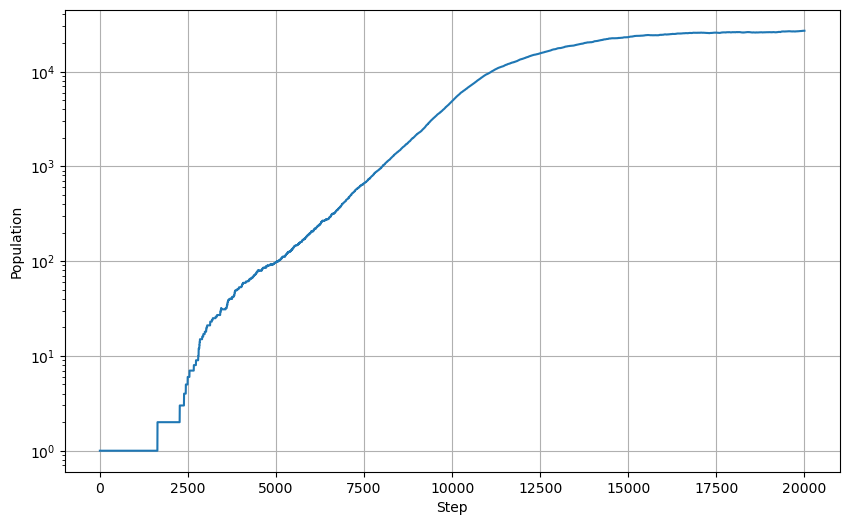

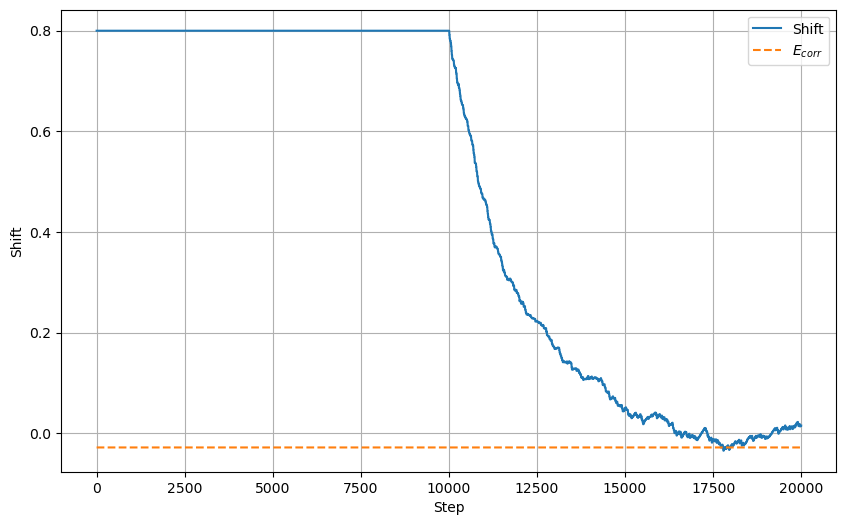

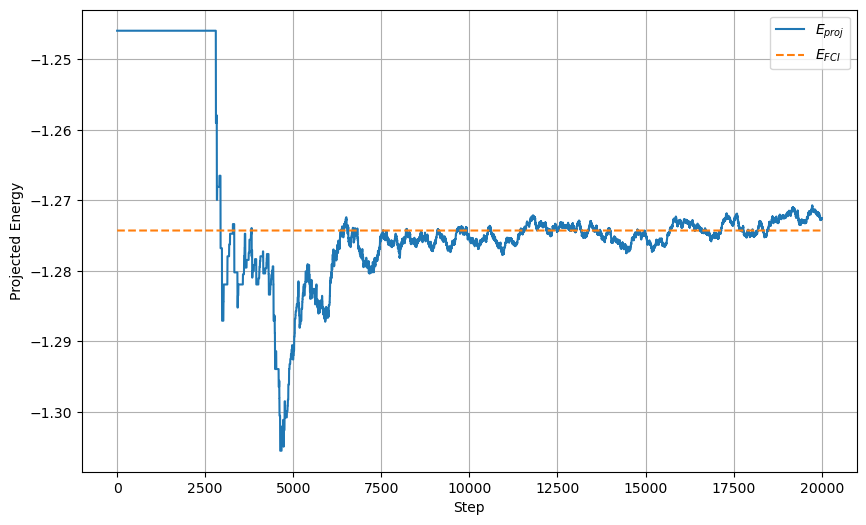

In [50]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.8, n_steps=20000, n_prod=10000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
# print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ STO-3G
FCI行列は225x225

--- K Matrix shape:(225, 225) ---
[[ 0.00000000e+00  1.27143113e-08 -1.26874938e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143113e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26874938e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.39953052e+00
   1.29249641e-17 -2.83496841e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.29249641e-17
   6.44660276e+00  2.86714800e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.83496841e-18
   2.86714800e-17  6.48034104e+00]]


  2%|▉                                            | 843/40000 [00:00<00:04, 8428.72it/s, E_proj=-7.914707, n_walkwers=5, shift=0.70000]

0 step
  1 walkers on 0th determinant
1000 step
  1 walkers on 0th determinant
2000 step
  3 walkers on 0th determinant
  1 walkers on 25th determinant
  -1 walkers on 160th determinant


 15%|██████                                   | 5867/40000 [00:00<00:02, 16793.29it/s, E_proj=-7.877137, n_walkwers=261, shift=0.70000]

3000 step
  7 walkers on 0th determinant
  2 walkers on 15th determinant
  -2 walkers on 1th determinant
  1 walkers on 25th determinant
  1 walkers on 63th determinant
4000 step
  14 walkers on 0th determinant
  -2 walkers on 1th determinant
  2 walkers on 25th determinant
  2 walkers on 15th determinant
  -1 walkers on 160th determinant
  -1 walkers on 96th determinant
  -1 walkers on 31th determinant
5000 step
  24 walkers on 0th determinant
  -4 walkers on 1th determinant
  3 walkers on 15th determinant
  3 walkers on 25th determinant
  -2 walkers on 160th determinant
  1 walkers on 10th determinant
  1 walkers on 151th determinant
  -1 walkers on 48th determinant
6000 step
  47 walkers on 0th determinant
  9 walkers on 15th determinant
  8 walkers on 25th determinant
  -6 walkers on 1th determinant
  -6 walkers on 160th determinant
  2 walkers on 10th determinant
  -2 walkers on 48th determinant
  2 walkers on 96th determinant
  1 walkers on 97th determinant
  1 walkers on 126th d

 32%|████████████▍                          | 12724/40000 [00:00<00:01, 18783.35it/s, E_proj=-7.875320, n_walkwers=4301, shift=0.70000]

9000 step
  343 walkers on 0th determinant
  37 walkers on 15th determinant
  28 walkers on 25th determinant
  -21 walkers on 1th determinant
  13 walkers on 10th determinant
  13 walkers on 151th determinant
  -10 walkers on 16th determinant
  -7 walkers on 48th determinant
  -7 walkers on 160th determinant
  -6 walkers on 96th determinant
  ... more
10000 step
  696 walkers on 0th determinant
  72 walkers on 15th determinant
  -54 walkers on 160th determinant
  48 walkers on 25th determinant
  48 walkers on 151th determinant
  -31 walkers on 1th determinant
  -23 walkers on 96th determinant
  -20 walkers on 16th determinant
  18 walkers on 10th determinant
  -14 walkers on 48th determinant
  ... more
11000 step
  1451 walkers on 0th determinant
  165 walkers on 15th determinant
  -154 walkers on 160th determinant
  95 walkers on 25th determinant
  -68 walkers on 48th determinant
  67 walkers on 151th determinant
  -45 walkers on 1th determinant
  -34 walkers on 16th determinant
  -26

 43%|███████████████▊                     | 17041/40000 [00:00<00:01, 20227.93it/s, E_proj=-7.887071, n_walkwers=161178, shift=0.70000]

13000 step
  6057 walkers on 0th determinant
  566 walkers on 15th determinant
  411 walkers on 25th determinant
  394 walkers on 151th determinant
  -305 walkers on 160th determinant
  -224 walkers on 48th determinant
  -214 walkers on 96th determinant
  -193 walkers on 16th determinant
  -116 walkers on 1th determinant
  61 walkers on 10th determinant
  ... more
14000 step
  12612 walkers on 0th determinant
  1147 walkers on 15th determinant
  904 walkers on 25th determinant
  802 walkers on 151th determinant
  -760 walkers on 160th determinant
  -487 walkers on 96th determinant
  -455 walkers on 16th determinant
  -442 walkers on 48th determinant
  138 walkers on 10th determinant
  -134 walkers on 1th determinant
  ... more
15000 step
  25703 walkers on 0th determinant
  -2649 walkers on 160th determinant
  2158 walkers on 15th determinant
  1547 walkers on 25th determinant
  1175 walkers on 151th determinant
  -824 walkers on 16th determinant
  -674 walkers on 96th determinant
  -5

 53%|███████████████████▏                | 21313/40000 [00:01<00:00, 20793.50it/s, E_proj=-7.882275, n_walkwers=3932276, shift=0.35961]

18000 step
  219823 walkers on 0th determinant
  -18523 walkers on 160th determinant
  16970 walkers on 15th determinant
  16830 walkers on 25th determinant
  15430 walkers on 151th determinant
  -7643 walkers on 16th determinant
  -5008 walkers on 48th determinant
  -5000 walkers on 96th determinant
  2070 walkers on 10th determinant
  974 walkers on 1th determinant
  ... more
19000 step
  453524 walkers on 0th determinant
  -48175 walkers on 160th determinant
  32747 walkers on 25th determinant
  31866 walkers on 15th determinant
  25774 walkers on 151th determinant
  -15478 walkers on 16th determinant
  7314 walkers on 1th determinant
  -6312 walkers on 96th determinant
  4403 walkers on 10th determinant
  -2914 walkers on 48th determinant
  ... more
20000 step
  932840 walkers on 0th determinant
  -145388 walkers on 160th determinant
  64390 walkers on 15th determinant
  53545 walkers on 25th determinant
  45447 walkers on 151th determinant
  -34988 walkers on 48th determinant
  -2

 64%|██████████████████████▎            | 25479/40000 [00:01<00:00, 20483.29it/s, E_proj=-7.882485, n_walkwers=6712574, shift=-0.01786]

23000 step
  3447764 walkers on 0th determinant
  -409369 walkers on 160th determinant
  241748 walkers on 25th determinant
  190239 walkers on 15th determinant
  150073 walkers on 151th determinant
  -126858 walkers on 48th determinant
  -109843 walkers on 16th determinant
  -62339 walkers on 96th determinant
  52615 walkers on 1th determinant
  24560 walkers on 10th determinant
  ... more
24000 step
  3865068 walkers on 0th determinant
  -614682 walkers on 160th determinant
  375938 walkers on 25th determinant
  244950 walkers on 15th determinant
  211902 walkers on 151th determinant
  -126671 walkers on 48th determinant
  -125535 walkers on 16th determinant
  -81749 walkers on 96th determinant
  72447 walkers on 1th determinant
  24705 walkers on 10th determinant
  ... more
25000 step
  4346382 walkers on 0th determinant
  519869 walkers on 25th determinant
  -435550 walkers on 160th determinant
  324123 walkers on 15th determinant
  201003 walkers on 151th determinant
  -162952 wal

 74%|██████████████████████████▋         | 29585/40000 [00:01<00:00, 20297.25it/s, E_proj=-7.882884, n_walkwers=6752374, shift=0.01143]

27000 step
  4684057 walkers on 0th determinant
  -390666 walkers on 160th determinant
  307718 walkers on 25th determinant
  261305 walkers on 15th determinant
  166219 walkers on 151th determinant
  -137999 walkers on 48th determinant
  -121900 walkers on 16th determinant
  -116387 walkers on 96th determinant
  91030 walkers on 1th determinant
  26450 walkers on 10th determinant
  ... more
28000 step
  4431891 walkers on 0th determinant
  -553534 walkers on 160th determinant
  287745 walkers on 25th determinant
  230701 walkers on 151th determinant
  225772 walkers on 15th determinant
  -172845 walkers on 48th determinant
  -139774 walkers on 16th determinant
  99108 walkers on 1th determinant
  -79515 walkers on 96th determinant
  21176 walkers on 10th determinant
  ... more
29000 step
  4458018 walkers on 0th determinant
  -402690 walkers on 160th determinant
  273150 walkers on 25th determinant
  212687 walkers on 15th determinant
  208270 walkers on 151th determinant
  -169150 wa

 89%|███████████████████████████████▎   | 35755/40000 [00:01<00:00, 20511.75it/s, E_proj=-7.877918, n_walkwers=5783446, shift=-0.04943]

32000 step
  4867631 walkers on 0th determinant
  -890537 walkers on 160th determinant
  289369 walkers on 25th determinant
  235477 walkers on 15th determinant
  224672 walkers on 151th determinant
  -179437 walkers on 16th determinant
  -116517 walkers on 96th determinant
  -112878 walkers on 48th determinant
  103136 walkers on 1th determinant
  33741 walkers on 10th determinant
  ... more
33000 step
  5103254 walkers on 0th determinant
  -712488 walkers on 160th determinant
  348161 walkers on 25th determinant
  234527 walkers on 151th determinant
  207169 walkers on 15th determinant
  -171510 walkers on 48th determinant
  -146856 walkers on 16th determinant
  -129575 walkers on 96th determinant
  84094 walkers on 1th determinant
  32156 walkers on 10th determinant
  ... more
34000 step
  4756710 walkers on 0th determinant
  -540481 walkers on 160th determinant
  257973 walkers on 151th determinant
  241412 walkers on 25th determinant
  188710 walkers on 15th determinant
  -187201 

100%|███████████████████████████████████| 40000/40000 [00:02<00:00, 19431.17it/s, E_proj=-7.880511, n_walkwers=5258410, shift=-0.02283]


37000 step
  4003522 walkers on 0th determinant
  -331878 walkers on 160th determinant
  261580 walkers on 25th determinant
  -171124 walkers on 16th determinant
  143875 walkers on 15th determinant
  117681 walkers on 151th determinant
  70692 walkers on 1th determinant
  -53721 walkers on 96th determinant
  -26330 walkers on 48th determinant
  21157 walkers on 97th determinant
  ... more
38000 step
  3835009 walkers on 0th determinant
  -630840 walkers on 160th determinant
  308080 walkers on 25th determinant
  202066 walkers on 151th determinant
  -161335 walkers on 16th determinant
  129059 walkers on 15th determinant
  -96204 walkers on 96th determinant
  82192 walkers on 1th determinant
  -41620 walkers on 48th determinant
  23988 walkers on 111th determinant
  ... more
39000 step
  3718056 walkers on 0th determinant
  -384426 walkers on 160th determinant
  238811 walkers on 25th determinant
  199487 walkers on 151th determinant
  -149466 walkers on 16th determinant
  142896 walk

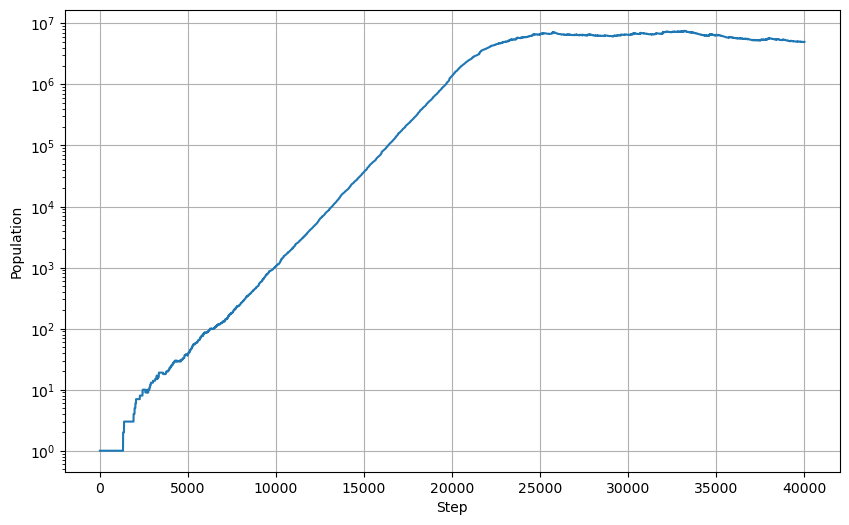

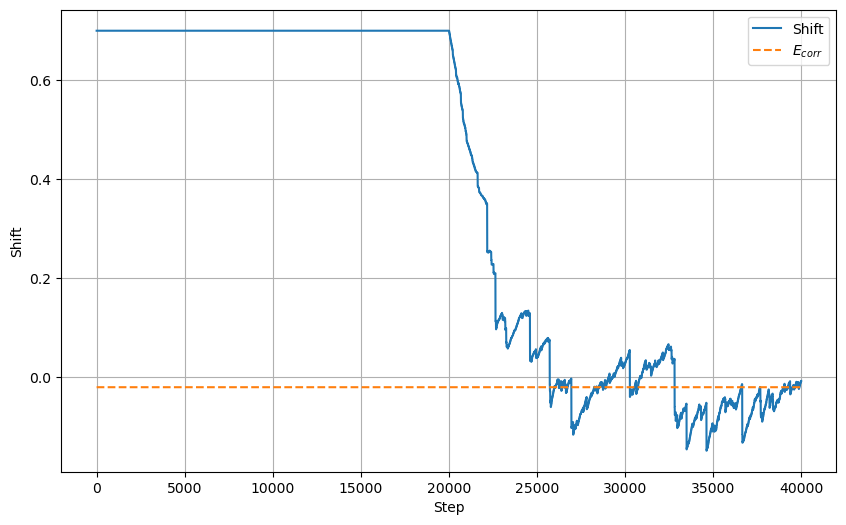

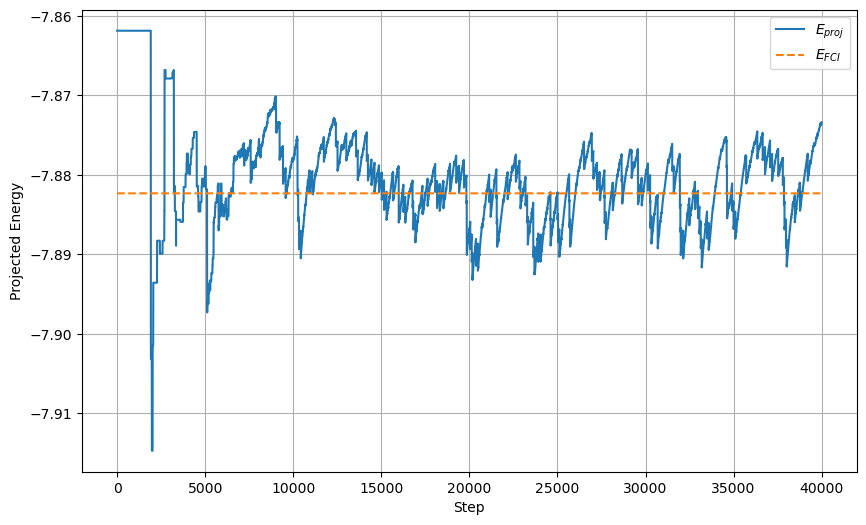

In [51]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    # basis="6-31g",
    # basis="6-31g(d)",
    # basis="6-31g(d,p)",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=40000, n_prod=20000, step_starting_shift_upd=20000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
# print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ 6-31g(d,p)

--- K Matrix shape:(29241, 29241) ---
[[ 0.00000000e+00 -8.13150971e-08 -8.36650006e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.13150971e-08  1.49183480e-01 -3.73250995e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.36650006e-09 -3.73250995e-03  2.21133798e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.59440770e+01
   3.55394972e-17 -8.88653878e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.55394972e-17
   1.72874354e+01  6.12515798e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.88653878e-18
   6.12515798e-17  1.73991629e+01]]


  4%|█▌                                           | 710/20000 [00:00<00:02, 7098.59it/s, E_proj=-7.984357, n_walkwers=5, shift=0.70000]

0 step
  1 walkers on 0th determinant
1000 step
  4 walkers on 0th determinant
  -1 walkers on 1071th determinant


 15%|██████▍                                    | 3018/20000 [00:00<00:02, 7568.75it/s, E_proj=-7.991840, n_walkwers=49, shift=0.70000]

2000 step
  8 walkers on 0th determinant
  -1 walkers on 1071th determinant
  1 walkers on 1047th determinant
3000 step
  20 walkers on 0th determinant
  4 walkers on 276th determinant
  -4 walkers on 3711th determinant
  3 walkers on 6261th determinant
  -2 walkers on 7414th determinant
  2 walkers on 1072th determinant
  1 walkers on 10266th determinant
  -1 walkers on 4834th determinant
  1 walkers on 9461th determinant
  -1 walkers on 6193th determinant
  ... more


 27%|███████████▏                              | 5325/20000 [00:00<00:01, 7493.54it/s, E_proj=-7.996855, n_walkwers=209, shift=0.70000]

4000 step
  31 walkers on 0th determinant
  -13 walkers on 1711th determinant
  2 walkers on 276th determinant
  2 walkers on 1029th determinant
  2 walkers on 1047th determinant
  1 walkers on 516th determinant
  1 walkers on 4791th determinant
  -1 walkers on 1071th determinant
  1 walkers on 23624th determinant
  1 walkers on 23587th determinant
  ... more
5000 step
  85 walkers on 0th determinant
  -44 walkers on 6157th determinant
  -27 walkers on 181th determinant
  -13 walkers on 1711th determinant
  -3 walkers on 3513th determinant
  3 walkers on 3612th determinant
  2 walkers on 2053th determinant
  2 walkers on 1047th determinant
  2 walkers on 7698th determinant
  -2 walkers on 1720th determinant
  ... more


 34%|█████████████▉                           | 6807/20000 [00:00<00:01, 6989.25it/s, E_proj=-7.986869, n_walkwers=1050, shift=0.70000]

6000 step
  178 walkers on 0th determinant
  -44 walkers on 6157th determinant
  -31 walkers on 181th determinant
  17 walkers on 276th determinant
  15 walkers on 17970th determinant
  -13 walkers on 1711th determinant
  11 walkers on 1721th determinant
  7 walkers on 2053th determinant
  6 walkers on 282th determinant
  -5 walkers on 1th determinant
  ... more
7000 step
  394 walkers on 0th determinant
  -110 walkers on 181th determinant
  -43 walkers on 6157th determinant
  -36 walkers on 1726th determinant
  29 walkers on 26268th determinant
  28 walkers on 207th determinant
  -17 walkers on 186th determinant
  -15 walkers on 1th determinant
  -15 walkers on 1711th determinant
  -14 walkers on 6263th determinant
  ... more


 44%|██████████████████                       | 8833/20000 [00:01<00:01, 6008.61it/s, E_proj=-7.984629, n_walkwers=4495, shift=0.70000]

8000 step
  821 walkers on 0th determinant
  337 walkers on 15597th determinant
  256 walkers on 26268th determinant
  142 walkers on 18046th determinant
  -121 walkers on 181th determinant
  -94 walkers on 20548th determinant
  -40 walkers on 6157th determinant
  -36 walkers on 2566th determinant
  -34 walkers on 633th determinant
  34 walkers on 18810th determinant
  ... more
9000 step
  1649 walkers on 0th determinant
  196 walkers on 10th determinant
  192 walkers on 15597th determinant
  187 walkers on 15571th determinant
  -158 walkers on 181th determinant
  -112 walkers on 171th determinant
  97 walkers on 535th determinant
  73 walkers on 2566th determinant
  -65 walkers on 27018th determinant
  -56 walkers on 1710th determinant
  ... more


 53%|█████████████████████                   | 10544/20000 [00:01<00:01, 4986.34it/s, E_proj=-7.989652, n_walkwers=1e+4, shift=0.70000]

10000 step
  3284 walkers on 0th determinant
  -733 walkers on 15652th determinant
  -465 walkers on 172th determinant
  317 walkers on 10th determinant
  -248 walkers on 4843th determinant
  -235 walkers on 26199th determinant
  230 walkers on 7716th determinant
  -211 walkers on 1711th determinant
  -195 walkers on 171th determinant
  -184 walkers on 23277th determinant
  ... more


 58%|██████████████████████▍                | 11518/20000 [00:01<00:01, 4462.56it/s, E_proj=-7.985218, n_walkwers=15036, shift=0.65594]

11000 step
  6091 walkers on 0th determinant
  -975 walkers on 1725th determinant
  -442 walkers on 172th determinant
  415 walkers on 10th determinant
  -334 walkers on 171th determinant
  261 walkers on 3435th determinant
  -253 walkers on 15652th determinant
  -211 walkers on 6156th determinant
  -204 walkers on 27018th determinant
  -192 walkers on 181th determinant
  ... more


 62%|████████████████████████▏              | 12398/20000 [00:02<00:01, 4110.04it/s, E_proj=-7.985867, n_walkwers=26840, shift=0.62150]

12000 step
  11724 walkers on 0th determinant
  -1964 walkers on 9408th determinant
  956 walkers on 4817th determinant
  -798 walkers on 1725th determinant
  -646 walkers on 4908th determinant
  640 walkers on 10th determinant
  -573 walkers on 6156th determinant
  -536 walkers on 171th determinant
  -523 walkers on 20th determinant
  -428 walkers on 172th determinant
  ... more


 68%|██████████████████████████▍            | 13579/20000 [00:02<00:01, 3602.65it/s, E_proj=-7.990867, n_walkwers=47951, shift=0.52076]

13000 step
  20609 walkers on 0th determinant
  -6653 walkers on 4988th determinant
  -1311 walkers on 9408th determinant
  -1201 walkers on 7815th determinant
  -1191 walkers on 1710th determinant
  855 walkers on 10th determinant
  -830 walkers on 171th determinant
  -614 walkers on 20523th determinant
  -607 walkers on 1725th determinant
  -579 walkers on 18060th determinant
  ... more


 71%|███████████████████████████▊           | 14282/20000 [00:02<00:01, 3276.10it/s, E_proj=-7.983857, n_walkwers=70740, shift=0.56553]

14000 step
  36810 walkers on 0th determinant
  -2748 walkers on 1081th determinant
  -1655 walkers on 1710th determinant
  1477 walkers on 100th determinant
  1323 walkers on 1712th determinant
  -1273 walkers on 171th determinant
  1247 walkers on 10th determinant
  -1117 walkers on 3594th determinant
  -1043 walkers on 3727th determinant
  -843 walkers on 9408th determinant
  ... more


 78%|█████████████████████████████▍        | 15506/20000 [00:03<00:01, 2795.80it/s, E_proj=-7.984201, n_walkwers=118114, shift=0.53943]

15000 step
  61138 walkers on 0th determinant
  5677 walkers on 153th determinant
  5317 walkers on 26199th determinant
  3095 walkers on 18046th determinant
  2275 walkers on 2034th determinant
  -2188 walkers on 1710th determinant
  -1844 walkers on 171th determinant
  -1720 walkers on 1081th determinant
  1577 walkers on 10th determinant
  -1370 walkers on 26371th determinant
  ... more


 82%|███████████████████████████████       | 16320/20000 [00:03<00:01, 2481.67it/s, E_proj=-7.985246, n_walkwers=288528, shift=0.00538]

16000 step
  100034 walkers on 0th determinant
  36294 walkers on 6247th determinant
  -24029 walkers on 3594th determinant
  18377 walkers on 15714th determinant
  9181 walkers on 9631th determinant
  -7018 walkers on 1726th determinant
  -6519 walkers on 2718th determinant
  4077 walkers on 535th determinant
  -3345 walkers on 20th determinant
  -3062 walkers on 6156th determinant
  ... more


 86%|████████████████████████████████▊     | 17284/20000 [00:03<00:01, 2326.01it/s, E_proj=-7.994773, n_walkwers=269196, shift=0.05898]

17000 step
  97681 walkers on 0th determinant
  -39047 walkers on 20565th determinant
  -22808 walkers on 1032th determinant
  -12130 walkers on 3594th determinant
  10238 walkers on 6247th determinant
  4483 walkers on 15742th determinant
  3795 walkers on 17191th determinant
  -3686 walkers on 3612th determinant
  -3357 walkers on 4635th determinant
  -2526 walkers on 171th determinant
  ... more


 92%|███████████████████████████████████   | 18431/20000 [00:04<00:00, 2216.25it/s, E_proj=-7.996781, n_walkwers=321221, shift=0.22655]

18000 step
  114688 walkers on 0th determinant
  -39285 walkers on 4833th determinant
  -16050 walkers on 6192th determinant
  -13287 walkers on 1032th determinant
  -13255 walkers on 11352th determinant
  12939 walkers on 15561th determinant
  -7062 walkers on 53th determinant
  -6715 walkers on 3594th determinant
  4256 walkers on 172th determinant
  -3982 walkers on 6363th determinant
  ... more


 96%|████████████████████████████████████▋ | 19291/20000 [00:04<00:00, 2007.42it/s, E_proj=-7.995209, n_walkwers=536438, shift=0.43556]

19000 step
  158391 walkers on 0th determinant
  -43575 walkers on 1032th determinant
  -40505 walkers on 6157th determinant
  -23835 walkers on 568th determinant
  -18376 walkers on 4833th determinant
  -17094 walkers on 649th determinant
  12889 walkers on 36th determinant
  9803 walkers on 4791th determinant
  9571 walkers on 3612th determinant
  -9402 walkers on 6192th determinant
  ... more


100%|██████████████████████████████████████| 20000/20000 [00:05<00:00, 3730.37it/s, E_proj=-7.995209, n_walkwers=536438, shift=0.43556]



---- Walkers (result) ----
  186561 walkers on 0th determinant
  -144787 walkers on 1720th determinant
  -71573 walkers on 9525th determinant
  43887 walkers on 15597th determinant
  -25359 walkers on 1032th determinant
  23360 walkers on 15571th determinant
  -21900 walkers on 6157th determinant
  20609 walkers on 1726th determinant
  -16953 walkers on 171th determinant
  -14010 walkers on 15577th determinant
  ... more
------------------------------
FCI Energy: -8.008671 Ha
FCIQMC Energy: -7.990596 ±  0.006823 Ha


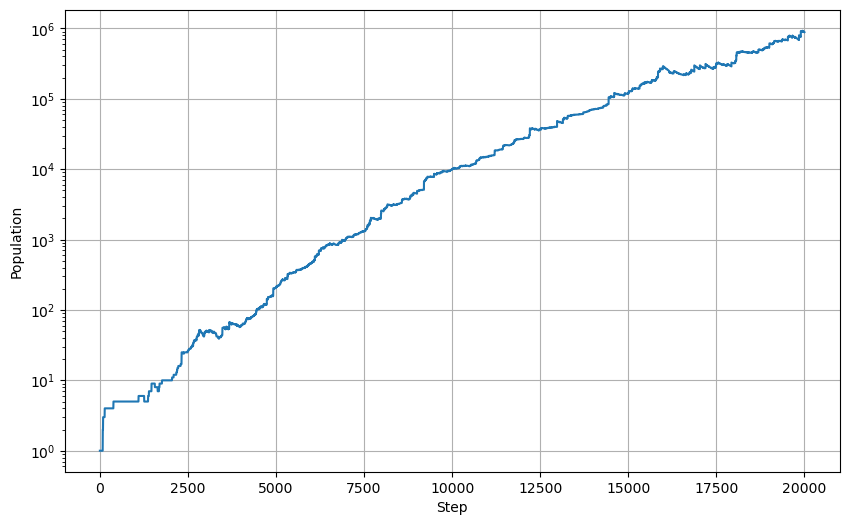

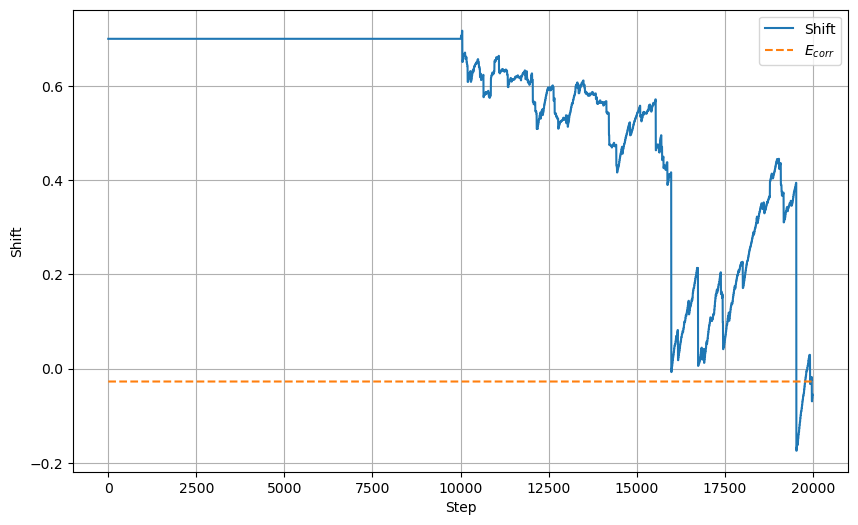

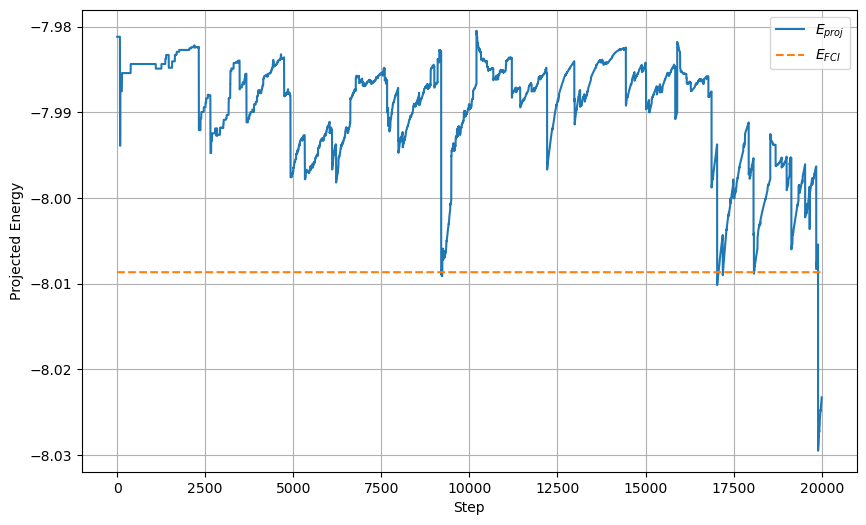

In [52]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="6-31g(d,p)",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=20000, n_prod=10000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
# print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ 分子 STO-3G, ステップ数ごとの標準偏差の確認
ステップ数を増やすと非常に実行に時間がかかる。

--- FCI Matrix ---
(225, 225)
[[-7.86186477e+00  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08 -7.70892352e+00 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02 -5.80885774e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.46233425e+00
   1.50382491e-17  8.78436185e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.50382491e-17
  -1.41526201e+00 -3.47698264e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.78436185e-18
  -3.47698264e-17 -1.38152373e+00]]
--- K Matrix ---
[[-1.77635684e-15  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 .

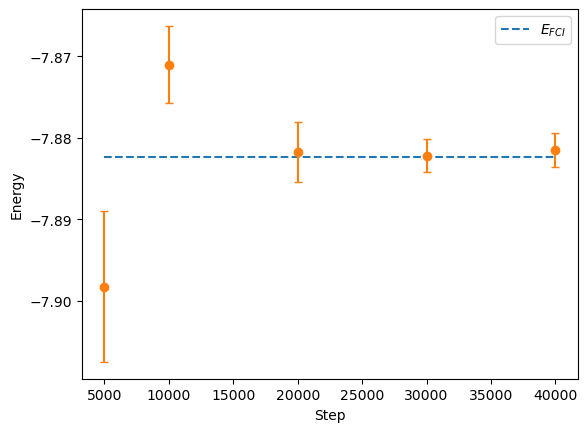

In [13]:
from pyscf import gto

n_steps_arr = [5000, 10000, 20000, 30000, 40000]

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    spin=0,      # singlet
    verbose=0
)

E = []
sd = []

for n_steps in n_steps_arr:
    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=1, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)

E_fci_arr = np.full_like(n_steps_arr, E_fci, dtype=float)
plt.plot(n_steps_arr, E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
plt.errorbar(n_steps_arr, E, yerr=sd, fmt='o', capsize=3)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()

## ${N_2}$ at equilibrium
FCI行列が巨大過ぎて生成出来ない。必要な成分のみ取ってくる実装（on the fly?）に変える必要がありそう

In [ ]:
from pyscf import gto

# N2 at equilibriumの定義
R_bohr = 2.068     # a0
R_ang = R_bohr * 0.529177

mol = gto.M(
    atom=f"N 0 0 0; N 0 0 {R_ang}",
    basis="cc-pVDZ",
    unit="Angstrom",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=1000, n_prod=500, step_starting_shift_upd=100)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## 外挿用（Det数:エネルギー）の共通関数を定義

In [5]:
def inverse_fit(N_det, E):
    x = 1.0 / N_det
    a, E_inf = np.polyfit(x, E, 1)
    fn = lambda N_det: a/N_det + E_inf    
    return a, E_inf, fn

def plot_extrapolation_to_inf_det(N_det, E, fn):    
    N_det_fit = np.linspace(N_det.min(), N_det.max(), 500)
    E_fit = fn(N_det_fit)

    plt.scatter(N_det, E, label="data")
    plt.plot(N_det_fit, E_fit, label=r"fit: $E_\infty + a/N$")
    plt.xlabel("Number of determinants")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

## ${H_2}$ 分子 基底数vs.エネルギーで外挿して、真のEを値を推測する

Starting FCIQMC with the 6-31g basis set.


100%|████████████████████████████████████████| 20000/20000 [00:02<00:00, 8316.68it/s, E_proj=-1.152258, n_walkwers=1227, shift=0.00628]


Starting FCIQMC with the 6-31g(d) basis set.


100%|█████████████████████████████████████████| 20000/20000 [00:01<00:00, 10041.10it/s, E_proj=-1.148768, n_walkwers=46, shift=0.19949]


Starting FCIQMC with the 6-31g(d,p) basis set.


100%|████████████████████████████████████████| 20000/20000 [00:05<00:00, 3535.62it/s, E_proj=-1.180135, n_walkwers=205, shift=-0.25342]


Starting FCIQMC with the 6-311G(d,p) basis set.


100%|█████████████████████████████████████████| 20000/20000 [00:08<00:00, 2375.84it/s, E_proj=-1.170090, n_walkwers=372, shift=0.01239]


All FCIQMC calculations have completed.
E_inf: -1.169159172070451


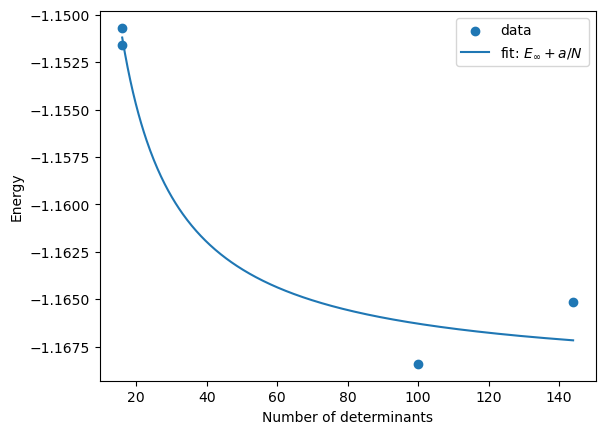

In [100]:
from pyscf import gto

# mol_1 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
mol_2 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g', verbose=0)
mol_3 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g(d)', verbose=0)
mol_4 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g(d,p)', verbose=0)
mol_5 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-311G(d,p)', verbose=0)
mols = [mol_2, mol_3, mol_4, mol_5]

n_steps = 20000
E = []
sd = []
N_det = np.zeros(len(mols))

for i, mol in enumerate(mols):
    print(f"Starting FCIQMC with the {mol.basis} basis set.")
    
    # determinantの数だけ欲しいが、molからは得られなかったので、
    # 冗長ではあるが、FCI Hamiltonianを生成して、行列の次元数を参照する
    H_mat, _, _ = build_hamiltonian(mol)

    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)
    N_det[i] = H_mat.shape[0]

print("All FCIQMC calculations have completed.")

_, E_inf, fn = inverse_fit(N_det, E)
print(f"E_inf: {E_inf}")

plot_extrapolation_to_inf_det(N_det, E, fn)


## ${LiH}$ 分子 基底数vs.エネルギーで外挿して、真のEを値を推測する

In [4]:
from pyscf import gto

mol_1 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='sto-3g', verbose=0)
mol_2 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g', verbose=0)
mol_3 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g(d)', verbose=0)
mol_4 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g(d,p)', verbose=0)
mols = [mol_1, mol_2, mol_3, mol_4]

n_steps = 40000
E = []
sd = []
N_det = np.zeros(len(mols))

for i, mol in enumerate(mols):
    print(f"Starting FCIQMC with the {mol.basis} basis set.")
    
    # determinantの数だけ欲しいが、molからは得られなかったので、
    # 冗長ではあるが、FCI Hamiltonianを生成して、行列の次元数を参照する
    H_mat, _, _ = build_hamiltonian(mol)

    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)
    N_det[i] = H_mat.shape[0]

print("All FCIQMC calculations have completed.")

Starting FCIQMC with the sto-3g basis set.


100%|███████████████████████████████████████| 40000/40000 [00:35<00:00, 1136.84it/s, E_proj=-7.880190, n_walkwers=9969, shift=-0.06585]


Starting FCIQMC with the 6-31g basis set.


100%|█████████████████████████████████████████| 40000/40000 [05:07<00:00, 130.04it/s, E_proj=-8.004459, n_walkwers=9421, shift=0.02323]


Starting FCIQMC with the 6-31g(d) basis set.


100%|████████████████████████████████████████| 40000/40000 [31:46<00:00, 20.98it/s, E_proj=-8.017295, n_walkwers=48951, shift=-0.04929]


Starting FCIQMC with the 6-31g(d,p) basis set.


100%|███████████████████████████████████████| 40000/40000 [1:27:23<00:00,  7.63it/s, E_proj=-8.008100, n_walkwers=94930, shift=0.10593]


All FCIQMC calculations have completed.


NameError: name 'inverse_fit' is not defined


Number of determinants: [  225.  3025. 14400. 29241.]
Energies: [np.float64(-7.8825610516142675), np.float64(-7.999504952870689), np.float64(-8.00476513085609), np.float64(-8.009363296702434)]
E_inf: -8.008650646649816


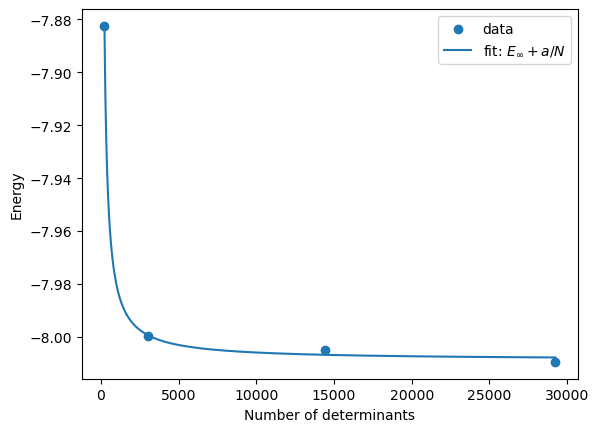

In [10]:
_, E_inf, fn = inverse_fit(N_det, E)

print(f"\nNumber of determinants: {N_det}")
print(f"Energies: {E}")
print(f"E_inf: {E_inf}")

plot_extrapolation_to_inf_det(N_det, E, fn)